In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import random
import string
import numpy as np
import sys, os
import torch.utils.data as data

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


all_characters = string.printable
number_of_characters = len(all_characters)


In [3]:
signs = ['Aries',
'Taurus',
'Gemini',
'Cancer',
'Leo',
'Virgo',
'Libra',
'Scorpio',
'Sagittarius',
'Capricorn',
'Aquarius',
'Pisces']

In [4]:
def character_to_label(character):
    """Returns a one-hot-encoded tensor given a character.
    
    Uses string.printable as a dictionary.
        
    Parameters
    ----------
    character : str
        A character
        
    Returns
    -------
    one_hot_tensor : Tensor of shape (1, number_of_characters)
        One-hot-encoded tensor
    """
    
    character_label = all_characters.find(character)
        
    return character_label


In [5]:
def string_to_labels(character_string):
    
    return map(lambda character: character_to_label(character), character_string)


In [6]:
def pad_sequence(seq, max_length, pad_label=100):
    
    seq += [pad_label for i in range(max_length - len(seq))]
    
    return seq


In [7]:
class HoroscopesGenerationDataset(data.Dataset):
    
    def __init__(self, csv_file_path, minimum_horoscopes_count=None, signs=None):
        
        
        self.horoscopes_dataframe = pd.read_csv(csv_file_path)
        
        if signs:
            
            self.horoscopes_dataframe = self.horoscopes_dataframe[self.horoscopes_dataframe.sign.isin(signs)]
            self.horoscopes_dataframe = self.horoscopes_dataframe.reset_index()
        
        if minimum_horoscopes_count:
        
            # Getting artists that have 70+ songs
            self.horoscopes_dataframe = self.horoscopes_dataframe.groupby('sign').filter(lambda x: len(x) > minimum_horoscopes_count)
            # Reindex .loc after we fetched random songs
            self.horoscopes_dataframe = self.horoscopes_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.horoscopes_dataframe.horoscope.str.len().max()
        
        whole_dataset_len = len(self.horoscopes_dataframe)
        
        self.indexes = range(whole_dataset_len)
        
        
        # Let's get unique artists and form a list
        self.signs_list = list(self.horoscopes_dataframe.sign.unique())
        
        # We will need the overall number of artists for 
        self.number_of_signs = len(self.signs_list)
    
    
    def __len__(self):
        
        return len(self.indexes)
    
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        
        sequence_raw_string = self.horoscopes_dataframe.loc[index].horoscope
        
        sequence_string_labels = string_to_labels(sequence_raw_string)
        
        sequence_length = len(sequence_string_labels) - 1
        
        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(input_string_labels, max_length=self.max_text_len)
        
        output_string_labels_padded = pad_sequence(output_string_labels, max_length=self.max_text_len, pad_label=-100)
        
        ## Adding the artist label
        sequence_raw_sign_name_string = self.horoscopes_dataframe.loc[index].sign

        sequence_sign_label = self.signs_list.index(sequence_raw_sign_name_string)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_sign_label]),
                torch.LongTensor([sequence_length]) )



In [8]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, signs, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_signs_batch = signs.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_signs_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[3]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_signs_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    signs_batch_sorted = torch.cat(splitted_signs_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    
    # We should probably repeat this over the whole input sequence
    signs_batch_sorted = signs_batch_sorted.expand_as(input_sequence_batch_sorted)

    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    signs_batch_sorted_transposed = signs_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, signs_batch_sorted_transposed, lengths_batch_sorted_list



In [9]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, num_conditions, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.num_conditions = num_conditions
        
        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        self.characters_encoder = nn.Embedding(input_size, hidden_size)
        
        self.conditions_encoder = nn.Embedding(num_conditions, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_conditions, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        characters_encoded = self.characters_encoder(input_sequences)
        conditions_endoded = self.conditions_encoder(input_sequences_conditions)
        
        encodings_combined = torch.cat((characters_encoded, conditions_endoded), dim=2)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(encodings_combined, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        
        logits = logits.transpose(0, 1).contiguous()
        
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden



In [10]:
trainset = HoroscopesGenerationDataset(csv_file_path='horoscopes.csv', signs=signs)

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                              shuffle=True, num_workers=4, drop_last=True)


In [11]:
rnn = RNN(input_size=len(all_characters) + 1,
          hidden_size=512,
          num_classes=len(all_characters),
          num_conditions=trainset.number_of_signs)

rnn.cuda()


RNN(
  (characters_encoder): Embedding(101, 512)
  (conditions_encoder): Embedding(12, 512)
  (lstm): LSTM(1024, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=100)
)

In [12]:
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()


In [13]:
def sample_from_rnn_conditionally(starting_sting="", sample_length=300, temperature=1, sign_label=0):
    
    sampled_string = starting_sting
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_sting) ).cuda()
    first_input = first_input.unsqueeze(1)

    # Expand the artist label to have the same size as input sequence
    # we duplicate it in every input
    sign_label_input = torch.LongTensor([sign_label]).expand_as(first_input)

    current_sequence_input = Variable(first_input)
    current_sign_input = Variable(sign_label_input.cuda())

    output, hidden = rnn(current_sequence_input, current_sign_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in xrange(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]
        current_sequence_input = Variable(predicted_label.unsqueeze(1))

        sign_label_input = torch.LongTensor([sign_label]).expand_as(current_sequence_input)
        current_sign_input = Variable(sign_label_input.cuda())

        output, hidden = rnn(current_sequence_input, current_sign_input, [1], hidden=hidden)
    
    return sampled_string

<IPython.core.display.Javascript object>


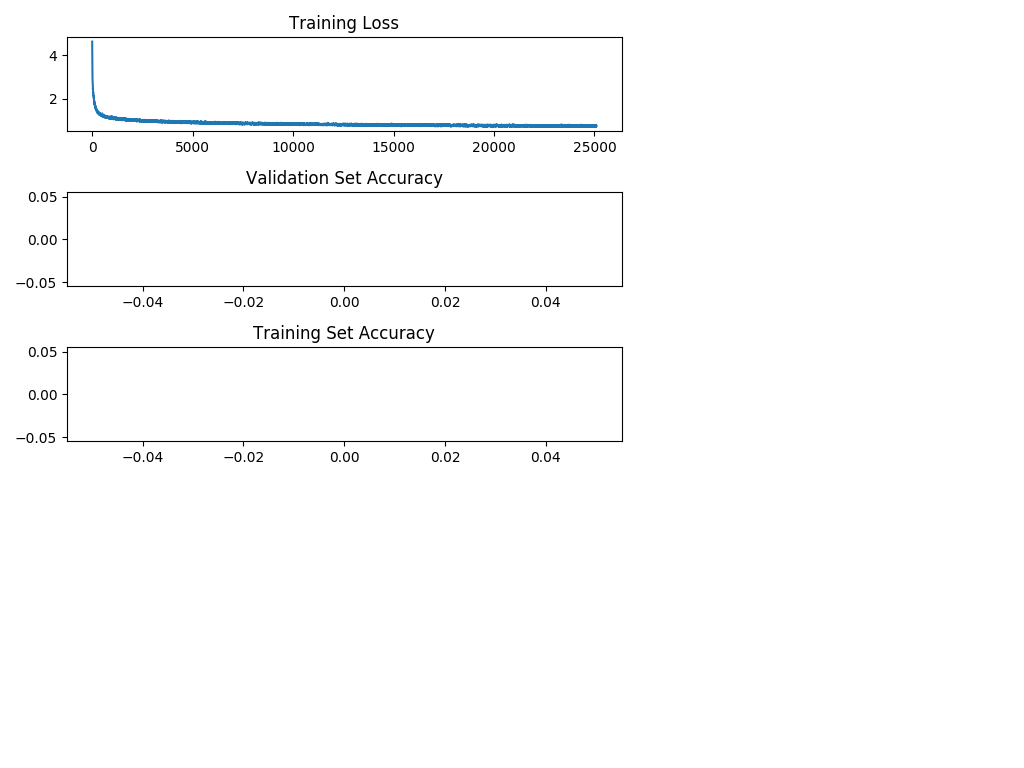

In [14]:
%matplotlib notebook

from matplotlib import pyplot as plt

# importing a list that can be binded with a figure and update
# the figure when being appended
from visualization import VizList

# Creating figure, axes and binding to lists 
f, (loss_axis, validation_axis, train_axis) = plt.subplots(3, 1)

loss_axis.plot([], [])
validation_axis.plot([], [])
train_axis.plot([], [])


loss_list = VizList()
validation_list = VizList()
train_list = VizList()

loss_list.bind_to_axis(loss_axis)
validation_list.bind_to_axis(validation_axis)
train_list.bind_to_axis(train_axis)

loss_axis.set_title('Training Loss')
validation_axis.set_title('Validation Set Accuracy')
train_axis.set_title('Training Set Accuracy')


plt.tight_layout()

In [17]:
clip = 1.0
epochs_number = 30
i = 0

for epoch_number in xrange(epochs_number):
    print("epoch: ", epoch_number)

    for batch in trainset_loader:
        if i % 10 == 0:
            print(i)

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, signs_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
        
        
        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
        signs_batch_var = Variable( signs_batch.cuda() )
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, signs_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append( loss.data[0] )
        loss.backward()

        #torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
        i += 1
    torch.save(rnn.state_dict(), 'results/horoscope_conditional_rnn.pth')
    

('epoch: ', 0)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
('epoch: ', 1)
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
('epoch: ', 2)
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2

15020
15030
15040
15050
15060
15070
15080
15090
15100
15110
15120
15130
15140
15150
15160
15170
15180
15190
15200
15210
15220
15230
15240
15250
15260
15270
15280
15290
15300
15310
15320
15330
15340
15350
15360
15370
('epoch: ', 19)
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
('epoch: ', 20)
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16

Ideally run till about 150000 iterations.... It will take for a while start at 9:10

In [2]:
torch.cuda.is_available()

False